# TKO_7092 Evaluation of Machine Learning Methods 2025

---

Student name: Niko Itänen

Student number: 2110412

Student email: nmitan@utu.fi

---

## Exercise 3

Complete the tasks given to you in the letter below. In your submission, explain clearly, precisely, and comprehensively why the cross-validation described in the letter failed, what is the correct way to perform cross-validation in the given scenario, and why the correct cross-validation method will give a reliable estimate of the generalisation performance. Then implement the correct cross-validation for the scenario and report its results.

Remember to follow all the general exercise guidelines that are stated in Moodle. Full points (2p) will be given for a submission that demonstrates a deep understanding of cross-validation on pair-input data and implements the requested cross-validation correctly (incl. reporting the results). Partial points (1p) will be given if there are small error(s) but the overall approach is correct. No points will be given if there are significant error(s).

The deadline of this exercise is **Wednesday 19 February 2025 at 11:59 PM**. Please contact Juho Heimonen (juaheim@utu.fi) if you have any questions about this exercise.

---


Dear Data Scientist,

I have a long-term research project regarding a specific set of proteins. I am attempting to discover small organic compounds that can bind strongly to these proteins and thus act as drugs. I have already made laboratory experiments to measure the affinities between some proteins and drug molecules.

My colleague is working on another set of proteins, and the objectives of his project are similar to mine. He has recently discovered thousands of new potential drug molecules. He asked me if I could find the pairs that have the strongest affinities among his proteins and drug molecules. Obviously I do not have the resources to measure all the possible pairs in my laboratory, so I need to prioritise. I decided to do this with the help of machine learning, but I have encountered a problem.

Here is what I have done so far: First I trained a K-nearest neighbours regressor with the parameter value K=10 using all the 400 measurements I had already made in the laboratory with my proteins and drug molecules. They comprise of 77 target proteins and 59 drug molecules. Then I performed a leave-one-out cross-validation with this same data to estimate the generalisation performance of the model. I used C-index and got a stellar score above 90%. Finally I used the model to predict the affinities of my colleague's proteins and drug molecules. The problem is: when I selected the highest predicted affinities and tried to verify them in the lab, I found that many of them are much lower in reality. My model clearly does not work despite the high cross-validation score.

Please explain why my estimation failed and how leave-one-out cross-validation should be performed to get a reliable estimate. Also, implement the correct leave-one-out cross-validation and report its results. I need to know whether it would be a waste of my resources if I were to use my model any further.

The data I used to create my model is available in the files `input.data`, `output.data` and `pairs.data` for you to use. The first file contains the features of the pairs, whereas the second contains their affinities. The third file contains the identifiers of the drug and target molecules of which the pairs are composed. The files are paired, i.e. the i<sup>*th*</sup> row in each file is about the same pair.

Looking forward to hearing from you soon.

Yours sincerely, \
Bio Scientist

---

#### Answer the questions about cross-validation on pair-input data

Starting points on where the Bio Scientist have started to work on this task are actually reasonable, but the problem lies in the perfomance estimation. Bio Scientist have used the leave-one-out cross-validation straight without accounting the pairwise depencencies. The issue here arises because we have multiple data points which are sharing the same protein or drug, and eventually leading to information leakage. While we performing basic leave-one-out cross-validation, removing only one pair at time does not prevent the model from seeing highlt similar data points druing training, meaning that we are getting overly optimistic peformance estimations that does not reflect how the model really perform with unseen data.

To obtain a more reliable perfomance estimation, we want to adjust the validation method by ensuring that all our data pairs whwich are containing the same protein or drug as the test pair are ignored from training. This way, our model is tested on genuinely novel protein-drug combination rather than those it has effectively seeen before.

In short, the current model overfits by learning patterns too well from the training data, decreasing its ability to generalize an unseen data. [1], [2]

Let's take a look how we can fix this.

#### Import libraries

In [ ]:
# Import the libraries you need.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

#### Load datasets

In [67]:
# Input data
inputData = pd.read_csv('data/input.data', sep=' ', header=None)

# Output data
outputData = pd.read_csv('data/output.data', header=None)

# Pairs data
pairsData = pd.read_csv('data/pairs.data', sep=' ', header=None).to_numpy()

# Print the shapes of the data
print(inputData.shape)
print(outputData.shape)
print(pairsData.shape)

(400, 67)
(400, 1)
(400, 2)


#### Write utility functions

In [ ]:
# Write the utility functions you need in your analysis.

# Function to perform pairwise leave-one-out cross-validation
def pairwise_loocv(input, output, pairs, k):
    # We get the number of samples
    n_samples = input.shape[0]
    
    # We define the lists where we store the true and predicted values
    test_list = []
    pred_list = []

    # Iterate prediction calculation for all the samples
    for i in range (n_samples):
        # We define the list where we store all the indices for the trainigg data
        train_indices = list(range(n_samples))

        # Now we find all the dependent pairs for the current test sample
        dependent_pairs = find_dependent_pairs(pairs, i)

        # We remove these pairs from the training data which has dependency with the test sample
        for idx in dependent_pairs:
            train_indices.remove(idx)

        # Form the training and test data for the current iteration
        # Because this is leave-one-out cross-validation, we only have one test sample
        # and the rest of the samples are used for training
        X_train, X_test = input.iloc[train_indices], input.iloc[[i]]
        Y_train, Y_test = output.iloc[train_indices], output.iloc[i]

        # Now we train the model and get the predictions for the test sample
        Y_pred = train_knn_model(X_train, Y_train, X_test, k)

        # Append the true and predicted values to the lists
        pred_list.append(Y_pred[0])
        test_list.append(Y_test[0])
        
    # Calculate the C-Index and return it
    return c_index(test_list, pred_list)


# Lets do the function for finding the dependent pairs from the pairs data
# Here we want to take the pairs data and the index of the datapoint we are interested in
def find_dependent_pairs(pairs, datapoint_id):
    # We create a list where depending pairs will be stored
    dependent_pairs = []

    # Define the current pair we are interedted in
    current_pair = pairs[datapoint_id]

    # Iterate the depencency check for all the pairs
    # If either of the proteins or drugs are same with the current pair, 
    # we add it to the dependent pairs list.
    for idx, pair in enumerate(pairs):
        if idx not in dependent_pairs and (current_pair[0] == pair[0] or current_pair[1] == pair[1]):
            dependent_pairs.append(idx)

    return dependent_pairs

# Function to calculate the C-Index [3]
def c_index(y_true, y_pred):
    # Define the variable for total combarable pairs
    n = 0
    # We define h_sum which is the sum of the number of concordant pairs and the number of ties.
    h_sum = 0
    # Now we iterate over the pairs of the true values and the predicted values
    for i in range(0, len(y_true)):
        t = y_true[i]
        p = y_pred[i]
        for j in range(i+1, len(y_true)):
            nt = y_true[j]
            np = y_pred[j]
            # If the true values are different, we increase the numbre of pairs
            if (t != nt):
                n += 1
                # Now we check if the prediction is correct or not
                if (p < np and t < nt) or (p > np and t > nt):
                    h_sum += 1
                elif p == np:
                    h_sum += 0.5
        # Return the C-index at the end of iteration
        return h_sum/n


# Function to train kNN model
def train_knn_model(X_train, Y_train, X_test, k):
    # We define the model
    model = KNeighborsRegressor(n_neighbors=k)

    # Fit the model
    model.fit(X_train, Y_train)

    # Do the predictions
    predictions = model.predict(X_test)

    return predictions


#### Implement and run cross-validation

In [69]:
# Now lets run the leave-one-out cross-validation with our data
c_index_score = pairwise_loocv(inputData, outputData, pairsData, 10)

# Print the C-Index score
print(f'C-Index score: {c_index_score}')

C-Index score: 0.581453634085213


### Analysis and Visualization

As we can see from the C-Index score with K-value of 10, the peformance of model is just a little bit better than random guessing. Reasons for this might be that there is small amount of data while the model should predict values that are in range between 0-1. The performance of the model can be enhanced by tuning its hyperparameters and collecting more data. I noticed that Bio Scientist's set K-value of 10 sounds pretty high. Let's find out if we can find better performance by choosing better K-value.

Let's do couple of iterations for the model with different K-values.

k=1 C-Index score: 0.7669172932330827
k=3 C-Index score: 0.7769423558897243
k=5 C-Index score: 0.6842105263157895
k=7 C-Index score: 0.6215538847117794
k=10 C-Index score: 0.581453634085213
k=15 C-Index score: 0.5864661654135338
k=20 C-Index score: 0.5864661654135338
k=25 C-Index score: 0.5889724310776943
k=30 C-Index score: 0.568922305764411


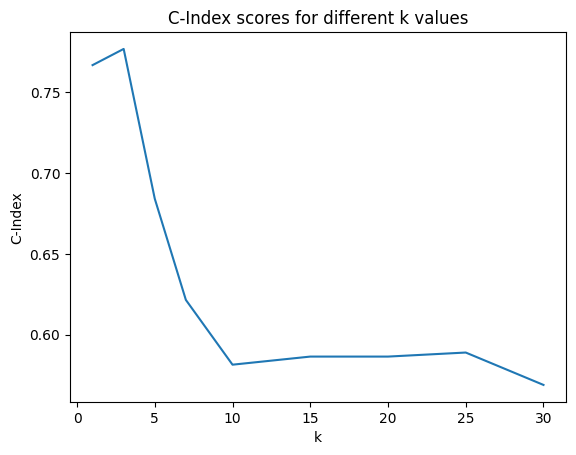

In [70]:
# Find the best k value for the kNN model
k_values = [1, 3, 5, 7, 10, 15, 20, 25, 30]
c_index_scores = []

for k in k_values:
    c_index_score = pairwise_loocv(inputData, outputData, pairsData, k)
    c_index_scores.append(c_index_score)
    print(f'k={k} C-Index score: {c_index_score}')

# Plot the C-Index scores for different k values
plt.plot(k_values, c_index_scores)
plt.xlabel('k')
plt.ylabel('C-Index')
plt.title('C-Index scores for different k values')
plt.show()

Now we have evaluated some different k values for model performance. As we can see from the plot, larger values of k tend to degrade our model performance.

The best performance is not 10 but actually 3, which gave us C-index score of 0.777, which is the highest among the tested values. To optimize predictive perforamnce of the model, a lower k-values is preferable, as increasing k beyond 3 results in a significant drop in the C-index.

### In Summary

Now we have fixed the problem where performance validation gave an overly optimistic accuracy estimation. Applying all pairwise dependent data points is a really important task, because without it we get overly optimistic results when training the model with them. In reality, the model will not perform as well in real-world applications because it cannot generalize to a single value without dependent pairs at all. We want to make sure that the predictions are actually calculated by using the independent data points for the unseen data.

Although our cross-validation has now been fixed, improvements can still be made. Our C-index is now around 0.581 with a K-value of 10, suggesting that our model performs only slightly better than guessing its values at random. To obtain valuable information, we want to achieve a much higher C-index. This can be corrected by using a more optimal hyperparameter for the k-NN model, such as 10, as we calculated. We also need to use much more data, as we currently have a very limited amount of data available, which can increase the accuracy of the model. Model selection could also be a way to improve these results. For example, using alternative regression models (such as Random Forest or SVR) could improve the prediction accuracy compared to k-NN.

### References:

[1] Lecture 3 Slides, MOOC 3: Problem-Dependent Resampling Techniques

[2] Tapio Pahikkala, Antti Airola, Sami Pietilä, Sushil Shakyawar, Agnieszka Szwajda, Jing Tang, Tero Aittokallio, Toward more realistic drug–target interaction predictions, Briefings in Bioinformatics, Volume 16, Issue 2, March 2015, Pages 325–337, https://doi.org/10.1093/bib/bbu010

[3] Schmid, M. et al. (2016). On the use of Harrell’s C for clinical risk prediction via random survival forests. (https://doi.org/10.1016/j.eswa.2016.07.018)